# Q1. What are the key factors influencing customer purchasing behavior?

**Part 1: Analyze historical sales data to identify patterns and trends.**
- UCI dataset (seasonal purchases, impulse buying, brand loyalty)

# **Import & Inspect Data**

In [ ]:
# mount drive
# from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load & inspect data
uci_clean = pd.read_csv('/content/drive/My Drive/DSA3101/online_retail_clean.csv')
uci_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Invoice Date,Invoice Time,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


# **Data Transformation**

### check for NA, change customer ID to int

In [ ]:
na_check = uci_clean.isna().sum()
print(na_check)

InvoiceNo            0
StockCode            0
Description        589
Quantity             0
UnitPrice            0
CustomerID      133574
Country              0
Invoice Date         0
Invoice Time         0
TotalPrice           0
dtype: int64


In [ ]:
uci_clean.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
UnitPrice,float64
CustomerID,float64
Country,object
Invoice Date,object
Invoice Time,object
TotalPrice,float64


In [ ]:
uci_clean['CustomerID'] = uci_clean['CustomerID'].fillna(0).astype(int)
uci_clean.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,535085.000000,535085.000000,535085.000000,535085.000000
mean,10.032073,4.166055,11466.564929,18.642732
std,217.312136,63.675467,6778.361988,373.993306
min,-80995.000000,0.000000,0.000000,-168469.600000
25%,1.000000,1.250000,12348.000000,3.750000
50%,3.000000,2.080000,14360.000000,9.900000
75%,10.000000,4.130000,16243.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


### Adjust for outliers in unit price and qty

In [ ]:
uci_drop = uci_clean[~uci_clean['Description'].isin(['POSTAGE', 'Manual', 'Carriage'])]
uci_drop = uci_drop[~uci_drop['Quantity'].isin([-80995, 80995, -74215, 74215])]
uci_drop = uci_drop[uci_drop['UnitPrice'] != uci_drop['UnitPrice'].min()]

In [ ]:
uci_drop.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,531394.000000,531394.000000,531394.000000,531394.000000
mean,9.954681,3.316092,11502.620001,18.389637
std,40.698379,5.344071,6763.829942,86.236349
min,-9360.000000,0.010000,0.000000,-6539.400000
25%,1.000000,1.250000,12362.000000,3.750000
50%,3.000000,2.080000,14389.000000,9.900000
75%,10.000000,4.130000,16255.000000,17.400000
max,4800.000000,1867.860000,18287.000000,38970.000000


# **EDA**

Use visualizations and summary statistics to explore the data:


- Time Series Analysis: Plot sales over time to identify trends and seasonality.

- Sales by Product: Analyze sales by product categories to identify top performers.

- Sales by Region: Investigate geographic patterns in sales.

- Correlation Analysis: Examine relationships between variables, such as promotions and sales volume.

# (a) Seasonal Purchase Analysis - Ervin

Hypotheses
1. For autumn and winter, there will be more sales of cold-related items with descriptions containing keywords such as 'woolly', 'warmer', 'hot', 'cosy', 'christmas', 'gingerbread', etc.
2. For spring and summer, there will be more sales of outdoor-related items with descriptions containing keywords such as 'picnic', 'garden', 'jam', 'polkadot', 'tea', 'easter', etc.

To study seasonal changes in purchases, we will first identify the region that each country (of each purchase) belongs to. They are segregated as follows:

**Northern Hemisphere**
* United Kingdom
* France
* Netherlands
* Germany
* Norway
* Ireland
* Switzerland
* Spain
* Poland
* Portugal
* Italy
* Belgium
* Lithuania
* Japan
* Iceland
* Channel Islands
* Denmark
* Cyprus
* Sweden
* Austria
* Israel
* Finland
* Bahrain
* Greece
* Hong Kong
* Czech Republic
* Canada
* USA
* Malta

**Southern Hemisphere**
* Australia
* Brazil
* South Africa

**Near the Equator**
* Singapore
* Lebanon
* United Arab Emirates
* Saudi Arabia

Following this, we determine the seasonal months within each region as follows:

**Seasonal purchase (northern hemisphere)**
* WINTER: Dec-Feb inclusive
* SPRING: Mar-May inclusive
* SUMMER: Jun-Aug inclusive
* AUTUMN: Sept-Nov inclusive

**Seasonal purchase (southern hemisphere)**
* WINTER: Jun-Aug inclusive
* SPRING: Sept-Nov inclusive
* SUMMER: Dec-Feb inclusive
* AUTUMN: Mar-May inclusive

**Seasonal purchase (near the equator)**
* SUMMER: Jan-Dec

Based on the information above, we may now label the different seasons for each purchase using the specified country and the month purchased.

In [ ]:
Q1a = uci_drop.copy()

# Convert 'Invoice Date' to datetime
Q1a['Invoice Date'] = pd.to_datetime(Q1a['Invoice Date'])

# Define regions of countries
northern_hemisphere = ['United Kingdom', 'France', 'Netherlands', 'Germany', 'Norway', 'Ireland',
    'Switzerland', 'Spain', 'Poland', 'Portugal', 'Italy', 'Belgium', 'Lithuania',
    'Japan', 'Iceland', 'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
    'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Czech Republic', 'Canada',
    'USA', 'Malta']

southern_hemisphere = ['Australia', 'Brazil', 'South Africa']

near_equator = ['Singapore', 'Lebanon', 'United Arab Emirates', 'Saudi Arabia']

# Function to assign seasons based on country and the month in 'Invoice Date'
def get_season(row):
    month = row['Invoice Date'].month
    country = row['Country']

    if country in northern_hemisphere:
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'

    elif country in southern_hemisphere:
        if month in [12, 1, 2]:
            return 'Summer'
        elif month in [3, 4, 5]:
            return 'Autumn'
        elif month in [6, 7, 8]:
            return 'Winter'
        elif month in [9, 10, 11]:
            return 'Spring'

    elif country in near_equator:
        return 'Summer'

    else:
        return 'Unknown'

# Apply the function to create 'Season' column
Q1a['Season'] = Q1a.apply(get_season, axis=1)
print(Q1a.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country Invoice Date Invoice Time  \
0       2.55       17850  United Kingdom   2010-12-01     08:26:00   
1       3.39       17850  United Kingdom   2010-12-01     08:26:00   
2       2.75       17850  United Kingdom   2010-12-01     08:26:00   
3       3.39       17850  United Kingdom   2010-12-01     08:26:00   
4       3.39       17850  United Kingdom   2010-12-01     08:26:00   

   TotalPrice  Season  
0       15.30  Winter  
1       20.34  Winter  
2       22.00  Winter  
3       20.34  Winter  
4       20.34  Winter  


Now that an additional column 'Season' has been added to each purchase row, we may attempt to verify that cold-related items are indeed sold more during autumn and winter seasons, and outdoor-related items are sold more during spring and summer seasons.

To start, we will define which products are cold-related (e.g., woolly, warmer, hot, cosy, christmas, gingerbread, etc.) and which are outdoor-related (e.g., picnic, garden, jam, polkadot, tea, easter, etc.) using sample keywords. This can be done by creating a new column in the dataset that labels items based on their descriptions.

In [ ]:
# find keywords
def categorize_product(description):
    cold_items = ['WOOLLY', 'WARMER', 'HOT', 'COSY', 'CHRISTMAS', 'GINGERBREAD']
    outdoor_items = ['PICNIC', 'GARDEN', 'JAM', 'POLKADOT', 'TEA', 'EASTER']

    # account for NaN and floats
    description = str(description) if not pd.isnull(description) else ''
    if any(item in description for item in cold_items):
        return 'Cold-Related'
    elif any(item in description for item in outdoor_items):
        return 'Outdoor-Related'
    else:
        return 'Other'

# Apply the function to the Description column
Q1a['Category'] = Q1a['Description'].apply(categorize_product)
print(Q1a.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country Invoice Date Invoice Time  \
0       2.55       17850  United Kingdom   2010-12-01     08:26:00   
1       3.39       17850  United Kingdom   2010-12-01     08:26:00   
2       2.75       17850  United Kingdom   2010-12-01     08:26:00   
3       3.39       17850  United Kingdom   2010-12-01     08:26:00   
4       3.39       17850  United Kingdom   2010-12-01     08:26:00   

   TotalPrice  Season      Category  
0       15.30  Winter         Other  
1       20.34  Winter         Other  
2       22.00  Winter         Ot

Once the products are categorized, we can group the sales data by season and product category. This will allow us to see how the sales of cold-related and outdoor-related items fluctuate across seasons.

In [ ]:
# Grouping by Season and Category to calculate the total quantity sold
seasonal_sales = Q1a.groupby(['Season', 'Category'])['Quantity'].sum().reset_index()

# Display seasonal sales data
print(seasonal_sales)

     Season         Category  Quantity
0    Autumn     Cold-Related    309652
1    Autumn            Other   1477223
2    Autumn  Outdoor-Related    108899
3    Spring     Cold-Related     14468
4    Spring            Other    914292
5    Spring  Outdoor-Related    120440
6    Summer     Cold-Related     36492
7    Summer            Other   1015974
8    Summer  Outdoor-Related    114536
9   Unknown     Cold-Related        98
10  Unknown            Other      2893
11  Unknown  Outdoor-Related       304
12   Winter     Cold-Related     99841
13   Winter            Other    969772
14   Winter  Outdoor-Related    104974


Takeaway: results are as expected for spring and summer, with significantly more outdoor-related purchases than cold-related purchases in those seasons. There is also much more cold-related purchases than outdoor-related purchases in autumn, but the results are unexpected for winter, with more outdoor-related purchases than cold-related purchases. This could be due to the fact that customers are buying more outdoor-related goods in anticipation of spring.


# (b) Impulsive buyer analysis - Ervin

**Hypothesis:**

1. Customers exhibit strongly impulsive behaviour if they buy and cancel an order within a day.
2. Customers exhibit weakly impulsive behaviour and/or are particular about the quality of the good they buy if they buy and return an order (signified by a cancellation as well) within a week.

To commence our investigation, we will first identify cancellations denoted by purchases with InvoiceNo starting with "C".

Subsequently, we will group by CustomerID and use the Invoice Date column to calculate whether cancellations occur within the same day (for strongly impulsive) or within a week (for weakly impulsive).

We will then calculate the cancellation rate for each customer (i.e. the number of cancellations divided by the number of purchases for each year) and filter customers who have a cancellation rate >= 0.5 and who make a significant number of purchases (>5) to identify customers of interest.

**Definitions:**

* Cancellation rate: Number of times a customer makes cancellation per year / Number of purchases a customer makes per year.
* Benchmark for a significant number of purchases per year is more than 5.

In [ ]:
Q1b = uci_drop.copy()

# Add a column to indicate cancellations (True or False)
Q1b['IsCancellation'] = Q1b['InvoiceNo'].str.startswith('C', na=False)

# Convert 'Invoice Date' to datetime
Q1b['Invoice Date'] = pd.to_datetime(Q1b['Invoice Date'])

# Add a column to mark the year of the purchase
Q1b['Year'] = Q1b['Invoice Date'].dt.year

# Add a column to mark the day of purchase for later comparison
Q1b['PurchaseDate'] = Q1b['Invoice Date'].dt.date

# Function to find impulsive customers
def find_impulsive_customers(df):
    # Create a DataFrame to store customer metrics
    impulsive_customers = pd.DataFrame()

    # Group by CustomerID and Year
    customer_group = df.groupby(['CustomerID', 'Year'])

    # Iterate over each customer-year group
    for (customer_id, year), group in customer_group:
        # Split the data into cancellations and purchases
        cancellations = group[group['IsCancellation'] == True]
        purchases = group[group['IsCancellation'] == False]

        # If there are no purchases or cancellations, skip this group
        if len(purchases) == 0 or len(cancellations) == 0:
            continue

        # Calculate the number of purchases and cancellations
        total_purchases = len(purchases)
        total_cancellations = len(cancellations)

        # Find strongly and weakly impulsive behaviors
        strongly_impulsive = 0
        weakly_impulsive = 0

        for _, cancellation in cancellations.iterrows():
            # Find the time difference between purchases and cancellations
            purchase_times = purchases['Invoice Date'].values
            cancellation_time = cancellation['Invoice Date']

            # Check if cancellation happens within a day (strongly impulsive)
            if any(abs((cancellation_time - purchase_time).days) <= 1 for purchase_time in purchase_times):
                strongly_impulsive += 1
            # Check if cancellation happens within a week (weakly impulsive)
            elif any(abs((cancellation_time - purchase_time).days) <= 7 for purchase_time in purchase_times):
                weakly_impulsive += 1

        # Calculate the cancellation rate
        cancellation_rate = total_cancellations / total_purchases

        # Check if cancellation rate >= 0.5 and the customer has more than 5 purchases
        if cancellation_rate >= 0.5 and total_purchases > 5:
            impulsive_customers = pd.concat([impulsive_customers, pd.DataFrame([{
                'CustomerID': customer_id,
                'Year': year,
                'TotalPurchases': total_purchases,
                'TotalCancellations': total_cancellations,
                'CancellationRate': cancellation_rate,
                'StronglyImpulsive': strongly_impulsive,
                'WeaklyImpulsive': weakly_impulsive
            }])], ignore_index=True)

    return impulsive_customers

impulsive_customers = find_impulsive_customers(Q1b)

# Display the result
print(impulsive_customers)

    CustomerID  Year  TotalPurchases  TotalCancellations  CancellationRate  \
0        12454  2011              15                  15          1.000000   
1        12504  2011               8                   6          0.750000   
2        12558  2011              11                  11          1.000000   
3        12607  2011             101                 101          1.000000   
4        13364  2011              10                  10          1.000000   
5        13672  2011               6                   9          1.500000   
6        13762  2011               7                   7          1.000000   
7        13791  2011              11                   6          0.545455   
8        13798  2010              39                  27          0.692308   
9        14109  2011               9                   5          0.555556   
10       14304  2011              17                  10          0.588235   
11       14513  2011              12                   6        

# (c) Brand Loyal Customer Analysis - MH

**Hypothesis**
- Customer who make repeated purchases of the same stock code consistently over a year are loyal to the brand
- Is occasion or geography related to brand loyalty?

### Clean data to question-specific context

In [ ]:
Q1c = uci_drop.copy()
# Combine date and time into a single datetime column

Q1c['PurchaseDateTime'] = pd.to_datetime(Q1c['Invoice Date'] + ' ' + Q1c['Invoice Time'])

# drop negative quantity
Q1c = Q1c[Q1c['Quantity'] > 0]

# drop customers with no ID
Q1c = Q1c[~Q1c['CustomerID'].isin([0])]

# drop qty anomaly 3114
Q1c = Q1c[~Q1c['Quantity'].isin([3114])]

# drop discounted items
Q1c = Q1c[~Q1c['StockCode'].isin(['D'])]

Q1c.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Invoice Date,Invoice Time,TotalPrice,PurchaseDateTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,08:26:00,15.30,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,08:26:00,22.00,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34,2010-12-01 08:26:00


### **Are customers brand loyal?**

- We define items as repeatedly purchased if number of purchases by the same customers is >2

- Drop those items that are not repeatedly purchased (not more than 2 times)

- Customers who have a large inclination to repeatedly purchase the same items are considered to be brand loyal

In [ ]:
# Step 1: Aggregate Purchase Data

loyalty_data = Q1c.groupby(['CustomerID', 'StockCode']).agg(
    purchase_count=('StockCode', 'size'),
    mean_quantity=('Quantity', 'mean'),
    first_purchase = ('PurchaseDateTime', 'min'),
    most_recent_purchase=('PurchaseDateTime', 'max')
).reset_index()

# delete rows with purchase_count > 1. This means they only bought this item once in span of two years
loyalty_data = loyalty_data[loyalty_data['purchase_count'] > 1]

# find days between first and last time same item was purchased by same user
loyalty_data['purchase_timeframe'] = (loyalty_data['most_recent_purchase'] - loyalty_data['first_purchase']).dt.days

# count purchase frequency. If 365, means item might be seasonal
loyalty_data['purchase_frequency'] = loyalty_data['purchase_timeframe'] / loyalty_data['purchase_count']

# brand loyal customers are defined by purchase_count > 2 or purchase_timeframe >= 365.
# If customer frequently makes purchase of same item, even in a short timeframe, it shows brand loyalty.
# If customer makes purchase once per year, it might be brand loyalty of seasonal item
loyalty_data = loyalty_data[(loyalty_data['purchase_count'] > 2) | (loyalty_data['purchase_timeframe'] >= 365)]

loyalty_data

,CustomerID,StockCode,purchase_count,mean_quantity,first_purchase,most_recent_purchase,purchase_timeframe,purchase_frequency
3,12347,20719,4,10.000000,2011-01-26 14:30:00,2011-12-07 15:52:00,315,78.750000
9,12347,21064,2,15.000000,2010-12-07 14:57:00,2011-12-07 15:52:00,365,182.500000
15,12347,21731,5,14.400000,2010-12-07 14:57:00,2011-12-07 15:52:00,365,73.000000
16,12347,21791,3,16.000000,2011-04-07 10:43:00,2011-10-31 12:25:00,207,69.000000
22,12347,22195,3,16.000000,2010-12-07 14:57:00,2011-10-31 12:25:00,327,109.000000
...,...,...,...,...,...,...,...,...
266126,18283,84991,3,1.666667,2011-04-21 16:37:00,2011-11-23 13:27:00,215,71.666667
266132,18283,85099B,10,1.700000,2011-01-06 14:14:00,2011-11-30 12:59:00,327,32.700000
266133,18283,85099F,7,1.428571,2011-01-06 14:14:00,2011-12-06 12:02:00,333,47.571429
266134,18283,85123A,4,2.500000,2011-02-28 10:30:00,2011-07-14 13:00:00,136,34.000000


- Things that are repeatedly purchased don't seem to be occasion-related

In [ ]:
stock_counts = loyalty_data['StockCode'].value_counts()
result = pd.merge(stock_counts, Q1c[['StockCode','Description']], on='StockCode', how='left').drop_duplicates()[['Description']]
result

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
2013,CREAM HANGING HEART T-LIGHT HOLDER
2023,JUMBO BAG RED RETROSPOT
3638,REGENCY CAKESTAND 3 TIER
5351,LUNCH BAG RED RETROSPOT
...,...
369965,YELLOW EASTER EGG HUNT START POST
369983,SKULLS STORAGE BOX LARGE
369999,TOAST ITS - DINOSAUR
370010,SET/4 BUTTERFLY MIRROR MAGNETS


- Find, out of all products purchased by a customer, what is the probability customer makes repeated purchase (more than two times) of it.
- We then use this probability as a proxy of the chance of a certain customer returning to make a repeated purchase of any item they bought

In [ ]:
# check out of all the products customer bought, what proportion do they go back and frequent same product
customer_counts = loyalty_data['CustomerID'].value_counts().reset_index()
customer_counts.columns = ['CustomerID', 'Numer of unique items purchased more than 2 times']
unique_stock_counts = Q1c.groupby('CustomerID')['StockCode'].nunique().reset_index()
merged_df = pd.merge(customer_counts, unique_stock_counts, on='CustomerID', how='inner')
merged_df['loyal_probability'] = (merged_df['Numer of unique items purchased more than 2 times']/merged_df['StockCode'])
merged_df.rename(columns={'StockCode': 'Number of unique items purchased'}, inplace=True)

merged_df

,CustomerID,Numer of unique items purchased more than 2 times,Number of unique items purchased,loyal_probability
0,17841,728,1322,0.550681
1,14911,681,1786,0.381299
2,14096,668,1118,0.597496
3,12748,604,1766,0.342016
4,14606,379,816,0.464461
...,...,...,...,...
1622,16621,1,22,0.045455
1623,13940,1,39,0.025641
1624,16566,1,14,0.071429
1625,13953,1,8,0.125000


- We define a customer to be goods-loyal if their probability of purchasing the same item they bought previously is > 0.2.

- Although 0.2 might seem like a small number, but it is the best resort now since product brand is not given and certain goods might belong to the same brand.

- We decide to use goods loyal as a proxy for brands loyal.

- We find that 322 customers are brand loyal, which is 7.66% of the total customers.

In [ ]:
# 322 customers identified to be brand loyal
total_customers = Q1c['CustomerID'].nunique()
loyal_customers = (merged_df['loyal_probability'] > 0.2).sum()
print("Total number of customers is: {}".format(total_customers))
print("Number of customers who are brand loyal is: {}".format(loyal_customers))
message = "Proportion of customers who are brand loyal is: {}%".format(round(loyal_customers/total_customers,4)*100)
print(message)

Total number of customers is: 4332
Number of customers who are brand loyal is: 332
Proportion of customers who are brand loyal is: 7.66%


### **We then want to investigate if brand loyal customers are correlated with their region**

We first obtain the country of each identified brand loyal customer

In [ ]:
loyal_customers_id = merged_df[merged_df['loyal_probability'] > 0.2]['CustomerID']
loyal_customer_data = pd.merge(loyal_customers_id, Q1c, on='CustomerID', how='left')
loyal_customer_data = loyal_customer_data.drop_duplicates(subset='CustomerID')[['CustomerID', 'Country']]
loyal_customer_data

,CustomerID,Country
0,17841,United Kingdom
7667,14911,Ireland
13335,14096,United Kingdom
18430,12748,United Kingdom
22827,14606,United Kingdom
...,...,...
115575,16462,United Kingdom
115578,14053,United Kingdom
115582,16532,United Kingdom
115586,13848,United Kingdom


We notice from the bar plot that most brand loyal customers come from the UK. But is this really true?

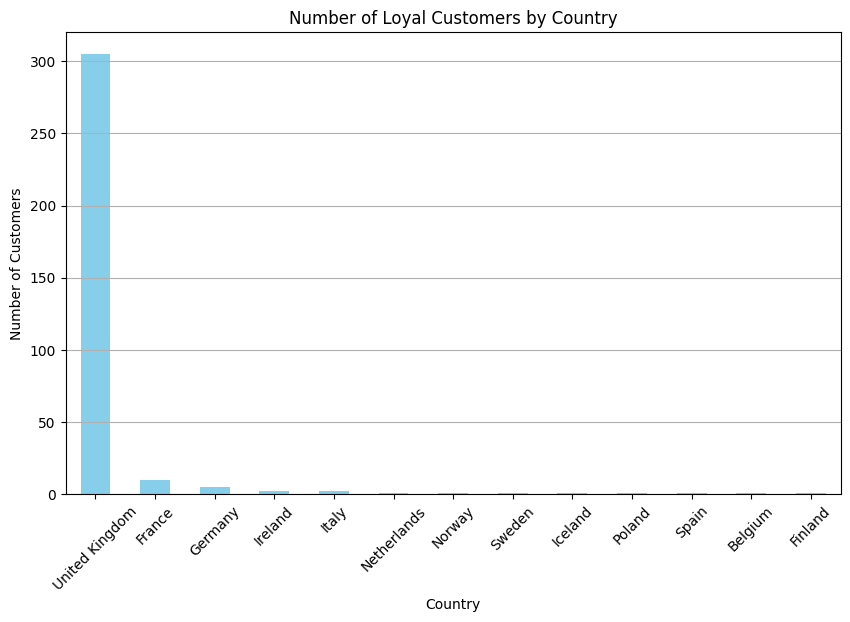

In [ ]:
# Count the number of customers per country
country_counts = loyal_customer_data['Country'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Loyal Customers by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Add grid lines for better readability
plt.show()

We then investigate the distribution of customers' country in the unfiltered dataset.

- Most customers are from the UK
- Data is originally skewed
- There is no geographical correlation with brand loyalty

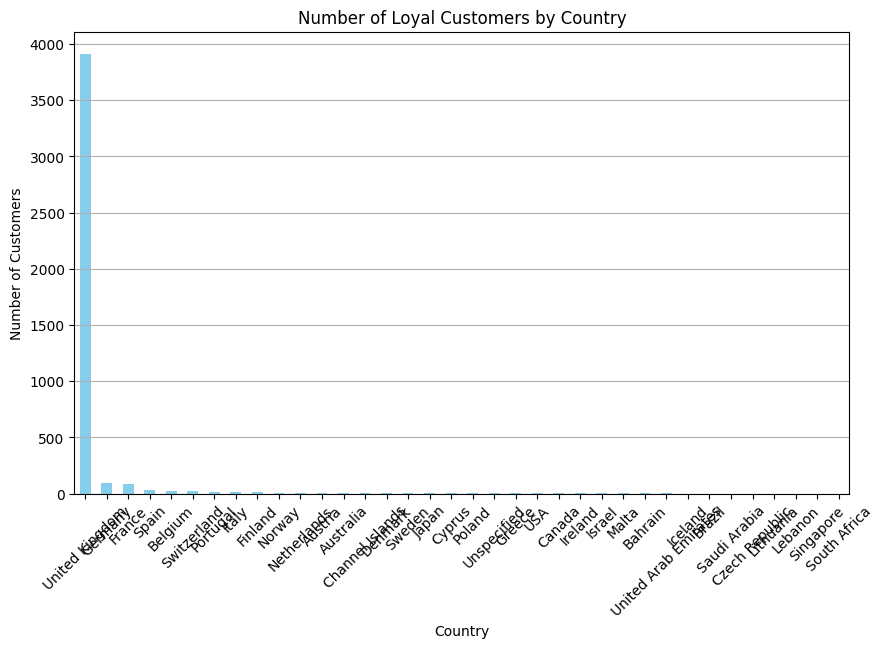

In [ ]:
Q1c_check = Q1c.drop_duplicates(subset='CustomerID')[['CustomerID', 'Country']]
# Count the number of customers per country
country_check = Q1c_check['Country'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
country_check.plot(kind='bar', color='skyblue')
plt.title('Number of Customers by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Add grid lines for better readability
plt.show()

# (d) Discount-Driven Customer Analysis - MH

**Hypothesis**
- Definition: avg discount percentage = total amount of discount in dollar per customer gets per year **/** total amount of dollar purchase made by per customer per year
- Customers are identified to be discount-driven if they enjoy a total of more than 5% discount on average across all purchases


In [ ]:
Q1d = uci_drop.copy()
Q1d.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Invoice Date,Invoice Time,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34


### Clean data to question-specific context

In [ ]:
discounted_items = Q1d[Q1d['StockCode'] == 'D']

# drop negative quantity
Q1d = Q1d[Q1d['Quantity'] > 0]

# drop customers with no ID
Q1d = Q1d[~Q1d['CustomerID'].isin([0])]

# drop qty anomaly 3114
Q1d = Q1d[~Q1d['Quantity'].isin([3114])]

# dataset without discounted items, only items bought
Q1d = Q1d[Q1d['StockCode'] != 'D']

### Find average discount per customer gets

Identify discount-driven customers

In [ ]:
# find total amt spent (full price) per customer per year
total_purchases = Q1d.groupby(['CustomerID'])['TotalPrice'].sum().reset_index()
total_purchases.columns = ['CustomerID','TotalSpent ($)']

# find total discount per customer enjoyed per year
total_discount = discounted_items.groupby(['CustomerID'])['TotalPrice'].sum().reset_index()
total_discount.columns = ['CustomerID', 'TotalDiscount ($)']

# find avg discount percentage per customer per year
Q1d_merged = pd.merge(total_discount, total_purchases, on=['CustomerID'], how='inner')
Q1d_merged['AvgDiscount (%)'] = Q1d_merged['TotalDiscount ($)']*-1*100 / Q1d_merged['TotalSpent ($)']
# -1 to turn totalDiscount into positive
# *100 to turn it into percentage
Q1d_merged

,CustomerID,TotalDiscount ($),TotalSpent ($),AvgDiscount (%)
0,12830,-66.24,6814.64,0.972025
1,12901,-7.20,17654.54,0.040783
2,13137,-45.33,3603.29,1.258017
3,13316,-162.24,5732.93,2.829967
4,13408,-345.39,28117.04,1.228401
5,13694,-247.00,65039.62,0.379769
6,14031,-64.27,17286.86,0.371785
7,14527,-688.84,8506.13,8.098160
8,14646,-206.40,279138.02,0.073942
9,14911,-434.51,140336.83,0.309619


In [ ]:
# find those customers who enjoyed >= 5% avg total discount consistently in 2010 and 2011. We classify those as discount driven

discount_driven = Q1d_merged[Q1d_merged['AvgDiscount (%)'] >= 5]
discount_driven.head()

,CustomerID,TotalDiscount ($),TotalSpent ($),AvgDiscount (%)
7,14527,-688.84,8506.13,8.098160
22,17940,-1987.86,2152.18,92.364951


**We conclude limited number of customers are discount-driven. Hence no further analysis could be done.**

# Fruit for thought: Global Economy recession effect
- 2010 global recovery from ASIA FINANCIAL CRISIS. Magnitude of recovery is large
- 2011, global economy continues to recover, but at a smaller magnitude

WILL THIS INFLUENCE OUR INVESTIGATION?